In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import time
from tqdm.notebook import tqdm

data_path = "../input/cassava-leaf-disease-classification"
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
train_img_path = os.path.join(data_path, "train_images")
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


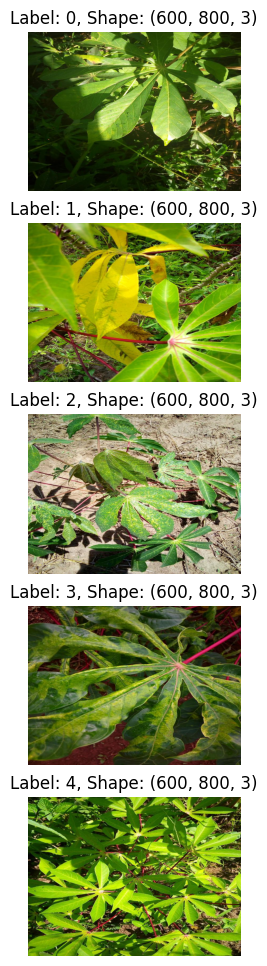

In [4]:
# EDA
def show_images(df:str, data_img_path:str, figsize=(10,12)):
    label_num = len(df['label'].unique())
    fig = plt.figure(figsize=figsize)
    
    for i in range(label_num):
        sample = df[df['label']==i]['image_id'].sample().reset_index(drop=True).iloc[0]
        img = cv2.imread(os.path.join(data_img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = fig.add_subplot(label_num, 1, i+1)
        plt.imshow(img)
        plt.title("Label: {}, Shape: {}".format(i, img.shape))
        plt.axis('off')
    plt.show()

show_images(train_df, train_img_path)

Total data num: 21397
Each label num:
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


(0.0, 1.0)

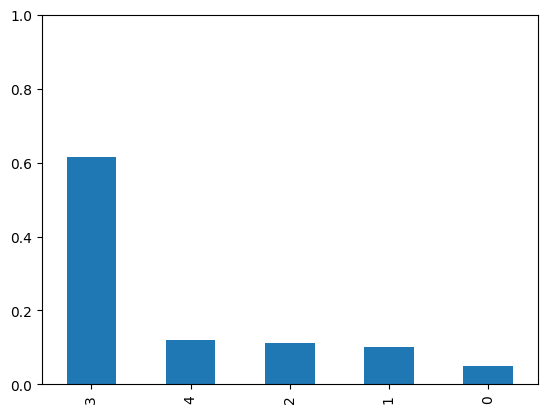

In [5]:
print("Total data num: {}".format(len(train_df)))
print("Each label num:")
print(train_df['label'].value_counts()/len(train_df))
(train_df['label'].value_counts()/len(train_df)).plot(kind='bar')
plt.ylim([0,1])

(299, 299, 3)


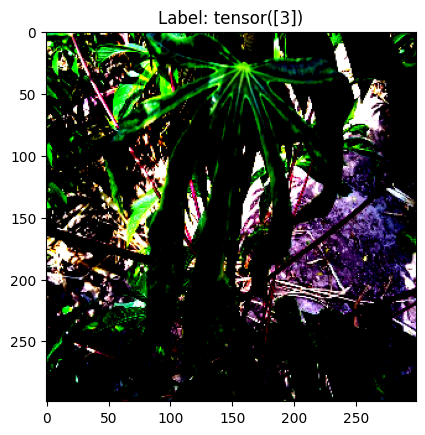

In [6]:
# create dataset and transform
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, data_img_path:str, phase:str='train', transform:object=None):
        self.df = df
        self.data_img_path = data_img_path
        self.phase = phase
        self.transform = transform
        
    def __getitem__(self, idx):
        sample = self.df['image_id'].iloc[idx]
        img = cv2.imread(os.path.join(self.data_img_path, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img, self.phase)
            
        if self.phase == 'test':
            return img
        
        label = self.df['label'].iloc[idx]
        return img, label
    
    def __len__(self):
        return len(self.df)
    
class Transform(object):
    def __init__(self, resize, mean, std):
        self.transform = {
            'train':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'val':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
            'test':A.Compose([
                A.Resize(resize, resize),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
        }
        
    def __call__(self, img, phase):
        return self.transform[phase](image=img)['image']
    
# set parameters 
resize = 299
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Check Dataset and Transform
transform = Transform(resize, mean, std)
dataset = CassavaDataset(train_df, train_img_path, 'train', transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
tmp = dataloader.__iter__()
img, label = next(tmp)
img = img.numpy().transpose(2,3,1,0).reshape(resize, resize, -1)
print(img.shape)
plt.imshow(img)
plt.title('Label: {}'.format(label))
plt.show()

In [8]:
import torch.nn.functional as F

# create model
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

class Xception(nn.Module):
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)


        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight, nonlinearity='conv2d')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform(m.weight, nonlinearity='linear')
        #-----------------------------

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def xception(**kwargs):
    model = Xception(**kwargs)
    return model

model = xception(num_classes=5)

/tmp/ipykernel_31/2437757077.py:115: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight, nonlinearity='conv2d')
/tmp/ipykernel_31/2437757077.py:120: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight, nonlinearity='linear')


In [13]:
def train_model(model, dataloader_dict, criterion, optimizer, device, epochs, scheduler):
    since = time.time()
    best_acc = 0.0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True
        
    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch+1, epochs))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels)
            
            if phase == 'train' and scheduler != None:
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = running_corrects / len(dataloader_dict[phase].dataset)
            
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_xception.pth')
        
            print('{} Loss: {:4f}, Acc: {:4f}'.format(phase, epoch_loss, epoch_acc))
        print()
    time_elapced = time.time() - since
    print('Trainning complete: {}m {}s'.format(time_elapced//60, time_elapced%60))
    print('Best Val Acc: {}'.format(best_acc))
    
transform = Transform(resize, mean, std)
train, val = train_test_split(train_df, test_size=0.2, random_state=42)
trainDataset = CassavaDataset(train, train_img_path, 'train', transform)
valDataset = CassavaDataset(val, train_img_path, 'val', transform)
train_dataloader = DataLoader(trainDataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(valDataset, batch_size=16, shuffle=False, num_workers=2)

dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model(model, dataloader_dict, criterion, optimizer, device, epochs=5, scheduler=scheduler)

Epoch: 1/5
----------


  0%|          | 0/1070 [00:00<?, ?it/s]

train Loss: 0.762645, Acc: 0.717591


  0%|          | 0/268 [00:00<?, ?it/s]

NameError: name 'running_acc' is not defined

In [ ]:
# test
model_path = os.path.join(data_path, 'beseline-xception/best_xception.pth')
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)

test_img_path = os.path.join(data_path, 'test_images')
test_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
testDataset = CassavaDataset(test_df, test_img_path, 'test', transform)
testDataloader = DataLoader(testDataset, batch_size=1, shuffle=True, num_works=2)

predictions = []

for inputs in testDataloader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.to('cpu')
    predictions.append(preds)
    
test_df['label'] = np.concatenate(predictions)
test_df.to_csv('submission.csv')

In [ ]:
data_img_path